In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython import display
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import multiprocessing as mp
import itertools
import time
import torchvision.transforms.functional as TF

import repitl
import repitl.kernel_utils as ku
import repitl.matrix_itl as itl
import repitl.difference_of_entropies as dent

import models
import utils.visual_utils as vu
from utils.data_utils.multiview_dataset_maker import *

import utils.training_utils as tu


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Create the multiview dataset

Wang, Weiran, et al. "On deep multi-view representation learning." International conference on machine learning. PMLR, 2015.

I create the multiview dataset to follow the same criteria as this paper.

Setup training multiview set

In [2]:
batch_size = 3000
remake = False
dataset_name = "rot_noisy"

multiview_dataset = rot_noisy_multiview_dataset(check_for_saved=True, noise_max=0, dataset_id=dataset_name, shuffle_view2 = True)

multiview_loader = DataLoader(dataset=multiview_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

multiview_test =  rot_noisy_multiview_dataset(check_for_saved=True, noise_max=0, is_testset=True, dataset_id=dataset_name, shuffle_view2=True, noisy_transform=None)

multiview_test_loader = DataLoader(dataset=multiview_test, 
                         batch_size=1000, 
                         shuffle=False)

 Visualize multiview set

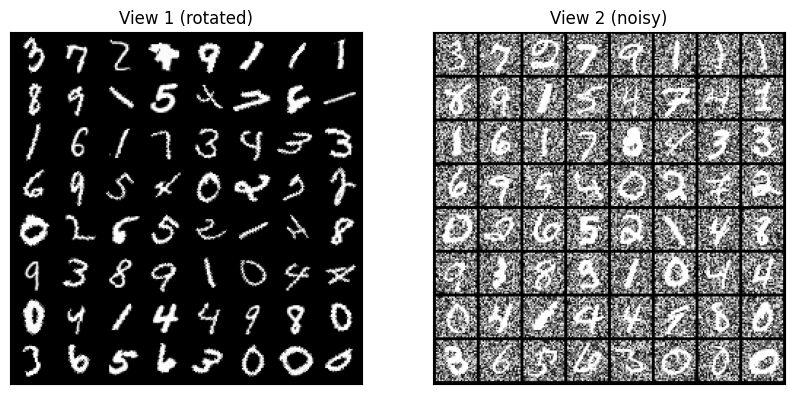

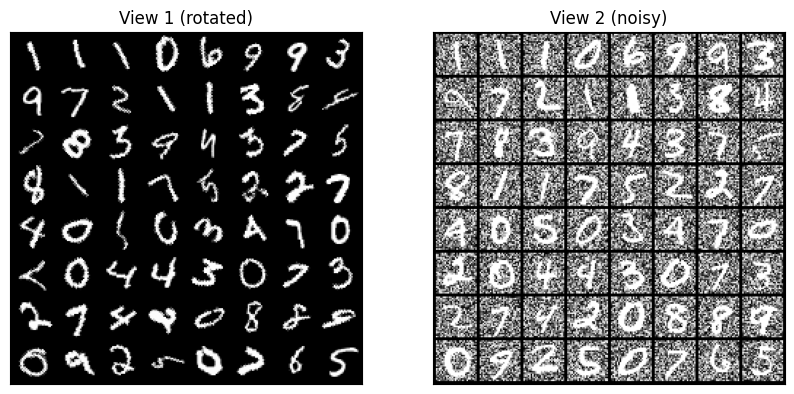

In [3]:
img_size = (1,28,28)
vu.visualize_multiview_dataset(multiview_loader, img_size=img_size)
vu.visualize_multiview_dataset(multiview_test_loader, img_size=img_size)


## Train disentangled model

In [4]:
disentangled_model = tu.train_model("mv_doe_conditional_recon", multiview_loader, multiview_test_loader, device=torch.device("cuda:0"), lr=0.0001, recon_dims=5,
        num_epochs=100, latent_dim=10, linear_size = 1024, img_size=(1,28,28), architecture="CNN",
        show_progress=True, num_classes=10, show_subprogress=True, experiment_name="disentangle", visualize_tsne=False)

Epoch 1
Batch 0 / 20  - Total 0.38 - Recon 0.380 - Latent 0.000058 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 2
Batch 0 / 20  - Total 0.35 - Recon 0.348 - Latent 0.000059 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 3
Batch 0 / 20  - Total 0.34 - Recon 0.336 - Latent 0.000121 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 4
Batch 0 / 20  - Total 0.33 - Recon 0.327 - Latent 0.000742 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 5
Batch 0 / 20  - Total 0.30 - Recon 0.319 - Latent 0.018043 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 6
Batch 0 / 20  - Total 0.08 - Recon 0.312 - Latent 0.228769 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 7
Batch 0 / 20  - Total -0.16 - Recon 0.304 - Latent 0.462984 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 8
Batch 0 / 20  - Total -0.28 - Recon 0.298 - Latent 0.573835 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 9
Batch 0 / 20  - Total -0.36 - Recon 0.291 - Latent 0.646589 - Classifier 0.000 - Sigx 1.00 - Sigy 1.00
Epoch 1

## Look at Reconstructions

<Figure size 800x800 with 0 Axes>

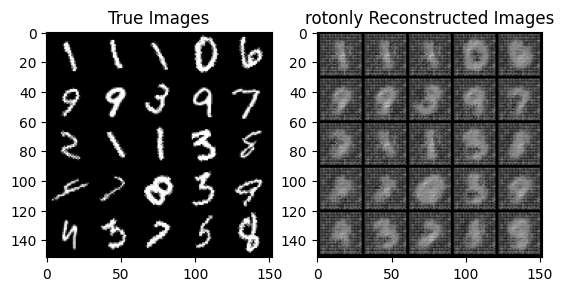

<Figure size 800x800 with 0 Axes>

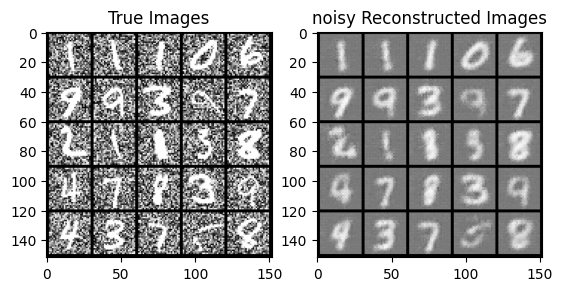

In [5]:
vu.see_reconstructions("rotonly", disentangled_model, multiview_test_loader, multiview=True, used_dataset=0)
vu.see_reconstructions("noisy", disentangled_model, multiview_test_loader, multiview=True, used_dataset=1)

# Dim Analysis

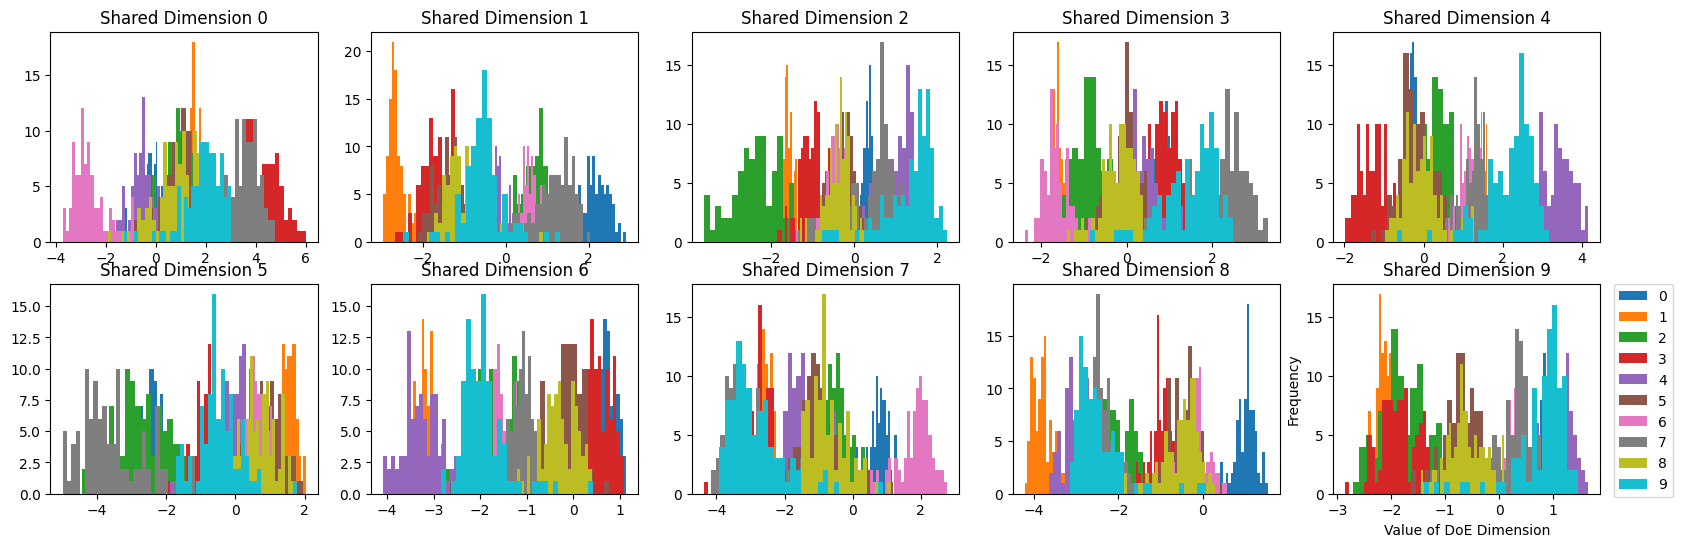

In [6]:

batch, labels = next(iter(multiview_test_loader))
rotbatch, normalbatch = batch

rotbatch = rotbatch.cuda()
normalbatch = normalbatch.cuda()

disentangled_model.change_view(0)
rot_encs = disentangled_model.get_whole_latent(rotbatch)

num_recon_dims = 5
fig, ax = plt.subplots(2,num_recon_dims, figsize=(20,6))

for i in range(num_recon_dims*2):
    rotrecon_dim = rot_encs[:, i].cpu().detach().numpy()
    rotmin, rotmax = np.min(rotrecon_dim), np.max(rotrecon_dim)

    for j in range(10):
        rotones_enc = [e for idx, e in enumerate(rotrecon_dim) if labels[idx].item()==j]
        ax[int(i/5)][i % 5].hist(rotones_enc, bins=30, label=j)

    ax[int(i/5)][i % 5].set_title("Shared Dimension %d" % i)
    
plt.xlabel("Value of DoE Dimension")
plt.ylabel("Frequency")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()


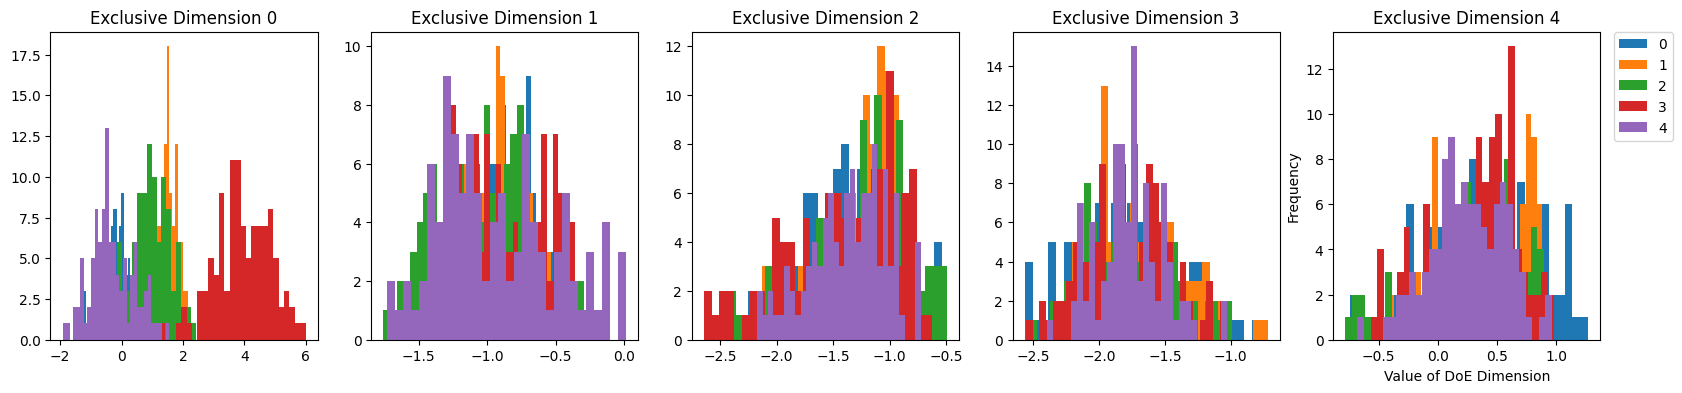

In [7]:
batch, labels = next(iter(multiview_test_loader))
rotbatch, normalbatch = batch

rotbatch = rotbatch.cuda()
normalbatch = normalbatch.cuda()

disentangled_model.change_view(0)
rot_encs = disentangled_model.get_whole_latent(rotbatch)

num_recon_dims = 5
fig, ax = plt.subplots(1,num_recon_dims, figsize=(20,4))

for i in range(5):
    rotrecon_dim = rot_encs[:, -i].cpu().detach().numpy()
    rotmin, rotmax = np.min(rotrecon_dim), np.max(rotrecon_dim)

    for j in range(5):
        rotones_enc = [e for idx, e in enumerate(rotrecon_dim) if labels[idx].item()==j]
        ax[i % 5].hist(rotones_enc, bins=30, label=j)

    ax[i % 5].set_title("Exclusive Dimension %d" % i)
    
plt.xlabel("Value of DoE Dimension")
plt.ylabel("Frequency")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()


# Independent Components

For better results, need to train the model for 250+ epochs.

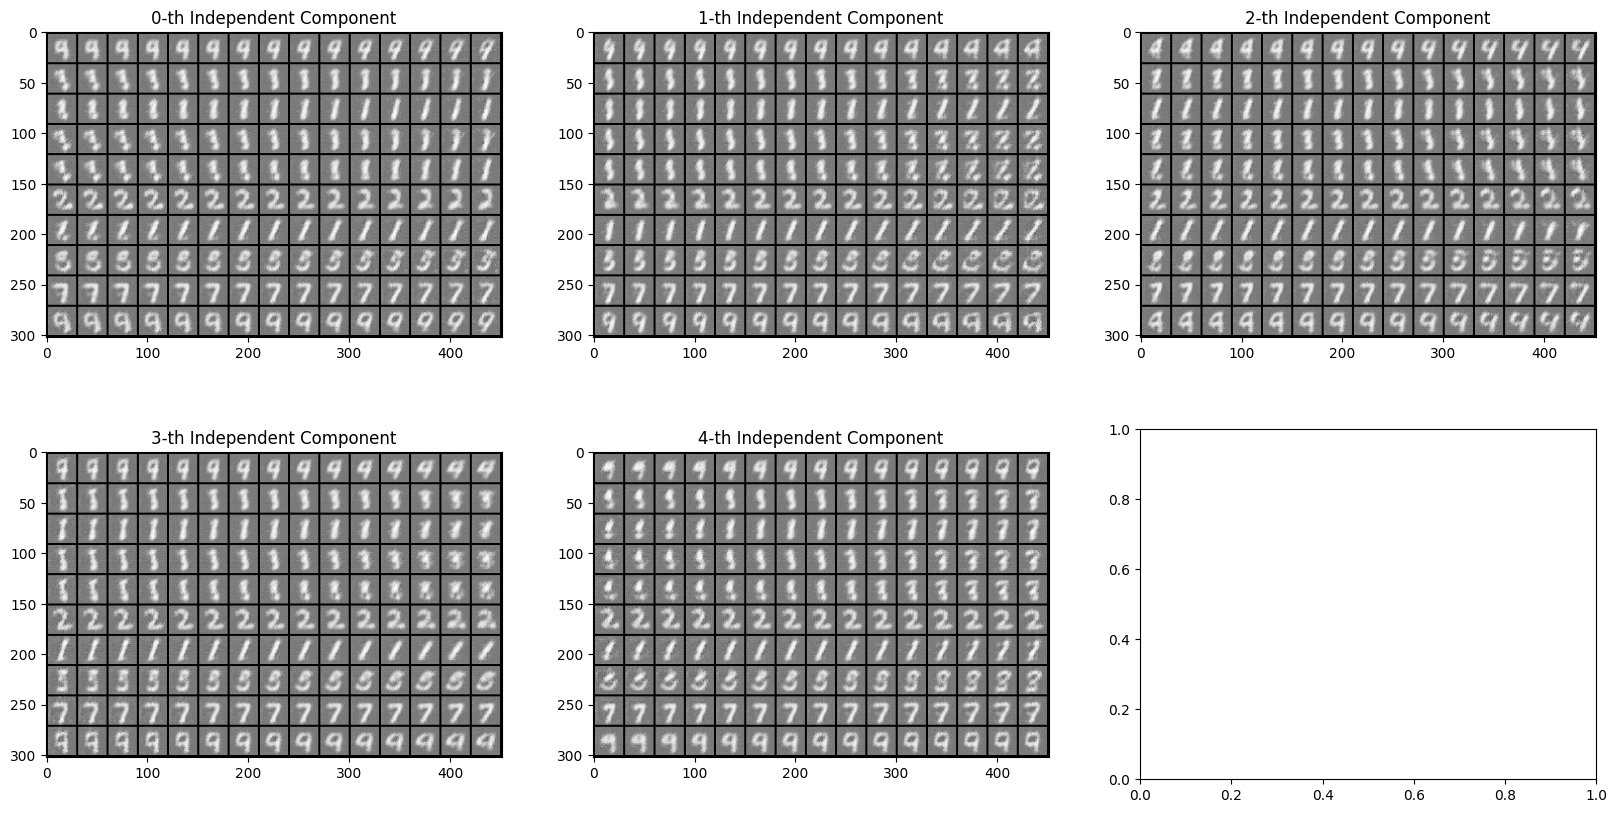

In [9]:
from sklearn.decomposition import fastica

numSteps = 15
numlatent = 5
rs = 22

batch, labels = next(iter(multiview_test_loader))
rotbatch, normalbatch = batch

rotbatch = rotbatch.cuda()
normalbatch = normalbatch.cuda()

relevantsamples = [43, 0, 2, 1, 11, 29, 25, 63, 38, 19]

disentangled_model.change_view(1)
normal_encs = disentangled_model.get_whole_latent(rotbatch)
exclusive_dims = normal_encs[:, -numlatent:]

disentangled_model.change_view(1)
X = exclusive_dims.detach().cpu()
K, W_inv, S, t = fastica(X, whiten=False, return_n_iter=True, random_state=rs)

W_inv = torch.tensor(W_inv, requires_grad=False).double()
W = torch.linalg.inv(W_inv)

steps_list = np.linspace(-1,1, numSteps)

fig, ax = plt.subplots(2,3, figsize=(20,10))
rots = torch.zeros(numSteps * len(relevantsamples), 1, 28, 28)

for i in range(numlatent):
    for idx, imgidx in enumerate(relevantsamples):
        start = disentangled_model.get_whole_latent(normalbatch[imgidx].reshape((1,1,28,28)))

        for stepidx, stepsize in enumerate(steps_list):
            newstep = start.clone()

            # transform to IC space
            newstep_ex = newstep[:, -numlatent:].double().cpu()
            newstep_trans = W @ newstep_ex.T
            
            # take step on IC
            newstep_trans[i] += stepsize
            
            # transform back to mixed space

            newstep_ex = W_inv @ newstep_trans

            newstep[:, -numlatent:] = newstep_ex.T

            rotdec = disentangled_model.decode_modified_latent(newstep)

            rots[stepidx + idx*numSteps, :] = rotdec[0]


    grid = torchvision.utils.make_grid(rots, nrow=numSteps)

    axrow = i // 3
    axcol = i % 3

    ax[axrow][axcol].imshow(grid.permute((1, 2, 0)))
    ax[axrow][axcol].set_title("%d-th Independent Component" % i)

#ax[-1,-1].axis('off')
plt.show()

